# Modeling

In [1]:
import seaborn as sns
import pandas as pd
import datetime as dt

## Distribution of Classes

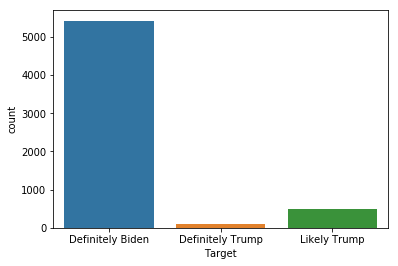

In [55]:
#Distribution of Target Values
Master_tweet_df = pd.read_csv('data/Master_Tweet_notebook.csv')
sns.countplot(x='Target',data=Master_tweet_df)

The distribution of Target Values isn't imbalanced enough to warrant further address.

## Pipeline Creation

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer

In [57]:
#splitting dataframe into numeric and categoric columns
numeric_features = ['likes_count', 'replies_count','retweets_count','word_count','avg_word_length','stopwords_count',
                   'char_count','MoE','Biden (D)','Trump (R)']
numeric_transformer = Pipeline([('imputer',SimpleImputer())])

categorical_features = ['Target']
categorical_transformer = Pipeline([('imputer',SimpleImputer(strategy='constant',fill_value='Likely Trump'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DummyClassifier())])

## Variable Designation

In [58]:
len(Master_tweet_df.columns)

36

In [71]:
X_values = Master_tweet_df.drop('Target',axis=1)
y_values = Master_tweet_df.iloc[:,-1]

In [72]:
X = X_values
y = y_values

In [73]:
X_values

,Unnamed: 0,Unnamed: 0.1,created_at,date,likes_count,replies_count,retweets_count,tweet,username,video,...,Sentiment,Poll,Start Date,End Date,Sample,MoE,Biden (D),Trump (R),Spread,Victory Spread
0,0,501,2020-02-11 17:20:08,2020-02-11 00:00:00,4374,464,2189,The World Health Organization has an official ...,nytimes,0,...,0.000000,QuinnipiacQuinnipiac,2/5/20,2/9/20,1519 RV,2.5,50.0,43.0,Biden +7,7.0
1,1,7317,2020-02-14 02:13:11,2020-02-13 00:00:00,0,0,0,Leading health experts warned on Feb. 12 that ...,tamiann02,0,...,0.375000,QuinnipiacQuinnipiac,2/5/20,2/9/20,1519 RV,2.5,50.0,43.0,Biden +7,7.0
2,2,7318,2020-02-13 21:28:24,2020-02-13 00:00:00,0,0,0,Leading health experts warned on Feb. 12 that ...,1val1richy,0,...,0.375000,QuinnipiacQuinnipiac,2/5/20,2/9/20,1519 RV,2.5,50.0,43.0,Biden +7,7.0
3,3,7319,2020-02-13 14:01:49,2020-02-13 00:00:00,0,0,0,"‚ÄúSo far, about 82 percent of the [covid-19 v...",kolsaw,0,...,0.048611,QuinnipiacQuinnipiac,2/5/20,2/9/20,1519 RV,2.5,50.0,43.0,Biden +7,7.0
4,4,7316,2020-02-15 23:04:26,2020-02-15 00:00:00,0,0,0,CDC director Dr. Robert Redfield says will bec...,_watch_observe_,0,...,0.216667,NPR/PBS/MaristNPR/PBS,2/13/20,2/16/20,1164 RV,3.7,50.0,44.0,Biden +6,6.0
5,5,1978,2020-02-16 19:56:00,2020-02-16 00:00:00,5,0,0,Americans should question the lack of informat...,shima3t,0,...,0.000000,ABC News/Wash PostABC/WP,2/14/20,2/17/20,913 RV,4,52.0,45.0,Biden +7,7.0
6,6,1979,2020-02-16 19:56:00,2020-02-16 00:00:00,5,0,0,Americans should question the lack of informat...,shima3t,0,...,0.000000,ABC News/Wash PostABC/WP,2/14/20,2/17/20,913 RV,4,52.0,45.0,Biden +7,7.0
7,7,7315,2020-02-17 18:02:26,2020-02-17 00:00:00,2,1,0,Several new confirmed cases of COVID-19 Corona...,narniaexpert,0,...,0.178788,ABC News/Wash PostABC/WP,2/14/20,2/17/20,913 RV,4,52.0,45.0,Biden +7,7.0
8,8,582,2020-02-20 01:37:02,2020-02-19 00:00:00,88,5,47,How epidemics like COVID-19 end (and how to en...,washingtonpost,0,...,0.000000,EmersonEmerson,2/16/20,2/18/20,1250 RV,2.7,48.0,52.0,Trump +4,-4.0
9,9,572,2020-02-20 01:37:02,2020-02-19 00:00:00,89,5,47,How epidemics like COVID-19 end (and how to en...,washingtonpost,0,...,0.000000,EmersonEmerson,2/16/20,2/18/20,1250 RV,2.7,48.0,52.0,Trump +4,-4.0


## Data Split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.15)

In [75]:
classifier = DummyClassifier()
clf.fit(X_train,y_train)

ValueError: A given column is not a column of the dataframe